# 1. Description   

a. **About this project:** After the new Coronavirus disease (COVID-19) case spread rapidly in Wuhan-China in December 2019, World Health Organization (WHO) confirmed that this is a dangerous virus which can be spreading from humans to humans through droplets and airborne. As for the prevention, wearing a face mask is essentials while going outside or meeting to others. However, some irresponsible people refuse to wear face mask with so many excuses. So it is necessary to build a model to determine whether someone is wearing a mask or not. This dataset is used for Face Mask Detection Classification with images.  

b. **Data Set:** [Kaggle](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)  
The dataset consists of almost 12K images which are almost 328.92MB in size. With two classes:     
- With mask.  
- Without mask.  

All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by [Jessica Li](https://www.kaggle.com/jessicali9530).  

c. **Members:**  
- Van Sy - 19495751  (Leader)  
- Nguyen Anh Toan - 19447201  
- Nguyen Van Phuc Nhan - 19440221  
- Nguyen Tien Sy - 19440181  
- Huynh Anh Tu  


# 2. Import libraries

In [31]:
import os # Getting path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# DenseNet201 with Tensorflow
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array # Prepare image
from tensorflow.keras import Model
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet201 # Model classify
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Save the best model weights
from IPython.display import Image
%matplotlib inline

Tensorflow version:  2.7.0


# 3. Data preprocessing

In [32]:
path = '../Face_Mask_Dataset'
train_dir = path+'/Train'
test_dir = path+'/Test'
val_dir = path+'/Validation'

In [33]:
TARGET_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 6
CLASSES = ['WithMask', 'WithoutMask']

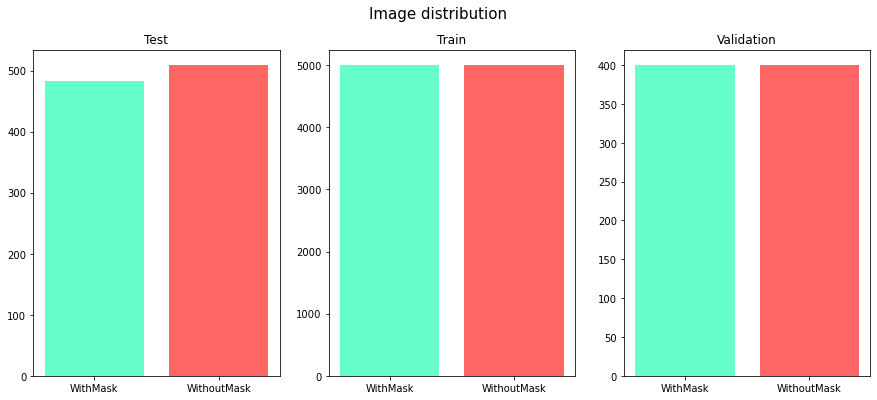

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for set_ in os.listdir(path):
    total = []
    ax = axes[os.listdir(path).index(set_)]
    for class_ in os.listdir(path+'/'+set_):
        count=len(os.listdir(path+'/'+set_+'/'+class_))
        total.append(count)
    ax.bar(CLASSES, total, color=['#66ffcc','#ff6666'])
    ax.set_title(set_)
plt.suptitle('Image distribution', size=15)
plt.show()

*Balanced data.*

In [35]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=10,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   zoom_range=0.25, 
                                   horizontal_flip=True, 
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory= path+'/Train', batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE)


test_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = test_datagen.flow_from_directory(path + '/Validation',target_size=TARGET_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [36]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'WithMask': 0, 'WithoutMask': 1}
{'WithMask': 0, 'WithoutMask': 1}


# 4. Classify Model

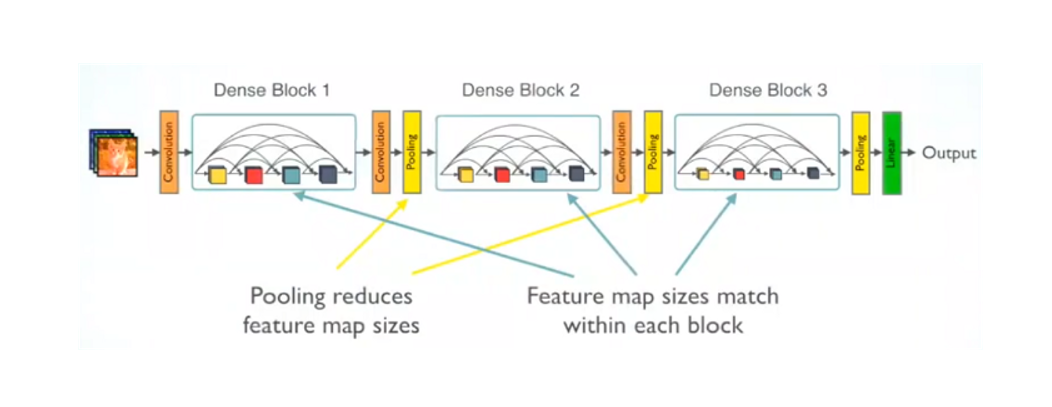

Here we use the Densenet model. This model is structurally similar to the Resnet model but has a few differences.
- Resnet add previous connection layer to next layer
- DenseNet forwards layers
<h3>=> The advantage of Densenet is: less parameters than Resnet but with the same accuracy. DenseNet resistance overfitting is very effective. Reduce vashing gradient. Reuse features more effectively

In [37]:
densenet_model = DenseNet201(input_shape=TARGET_SIZE+(3,), weights='imagenet', include_top=False)

74850304/74836368 [==============================] - 25s 0us/step


In [38]:
for layer in densenet_model.layers:
    layer.trainable = False

In [40]:
denseNet_model = DenseNet201(input_shape=TARGET_SIZE + (3,), weights='imagenet', include_top=False)
denseNet_model.trainable = False
flatten = Flatten()(denseNet_model.layers[-1].output)
fc = Dense(units=512, activation='relu')(flatten)
dropout = Dropout(0.35)(fc)
output = Dense(2, activation='softmax')(dropout)
   
model = Model(inputs=denseNet_model.input, outputs=output)

In [41]:
# model.summary()

In [42]:
# Defining a learning rate that decay with the help of a polynomial function of a root (power of 0.4) The learning rate range will be between 0.01 and 0.00001)
starter_learning_rate = 1e-2
end_learning_rate = 1e-6
decay_steps = 10000
lr = optimizers.schedules.PolynomialDecay(starter_learning_rate,decay_steps,end_learning_rate,power=0.4)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

# 5. Train model

In [43]:
my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=5, mode='auto',restore_best_weights=False, verbose=1),
                ModelCheckpoint(filepath='my_model.h5', monitor='accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)]

In [44]:
history = model.fit(train_generator,
                    epochs=EPOCHS, steps_per_epoch=len(train_generator), # How many mini_batchs we have inside each epoch.
                    validation_data=val_generator,
                    callbacks=[my_callbacks],
                    verbose=1)

print('\n\nDONE')
model.save('my_model.h5')

Epoch 1/6
157/157 [==============================] - ETA: 0s - loss: 4.2935 - accuracy: 0.9759
Epoch 00001: accuracy improved from -inf to 0.97590, saving model to my_model.h5
157/157 [==============================] - 490s 3s/step - loss: 4.2935 - accuracy: 0.9759 - val_loss: 0.0560 - val_accuracy: 0.9950
Epoch 2/6
157/157 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9937
Epoch 00002: accuracy improved from 0.97590 to 0.99370, saving model to my_model.h5
157/157 [==============================] - 426s 3s/step - loss: 0.0853 - accuracy: 0.9937 - val_loss: 0.0086 - val_accuracy: 0.9962
Epoch 3/6
157/157 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9956
Epoch 00003: accuracy improved from 0.99370 to 0.99560, saving model to my_model.h5
157/157 [==============================] - 433s 3s/step - loss: 0.0348 - accuracy: 0.9956 - val_loss: 0.0092 - val_accuracy: 0.9937
Epoch 4/6
157/157 [==============================] - ETA: 0s - loss: 0

*Training time over 30m.*

In [45]:
result = pd.DataFrame(history.history)
result

,loss,accuracy,val_loss,val_accuracy
0,4.293485,0.9759,0.056022,0.99500
1,0.085306,0.9937,0.008552,0.99625
2,0.034764,0.9956,0.009182,0.99375
3,0.017117,0.9960,0.008319,0.99625
4,0.018002,0.9964,0.008857,0.99625
5,0.010803,0.9975,0.010194,0.99625


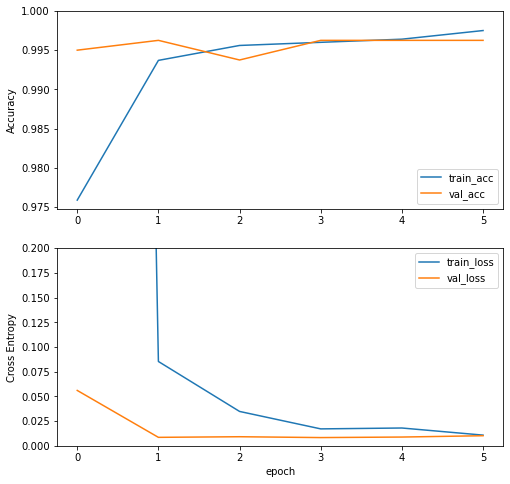

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(result['accuracy'], label='train_acc')
plt.plot(result['val_accuracy'], label='val_acc')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.subplot(2, 1, 2)
plt.plot(result['loss'], label='train_loss')
plt.plot(result['val_loss'], label='val_loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.ylim([0, 0.2])
plt.xlabel('epoch')
plt.show()

# 6. Model evaluation

In [47]:
test_generator = test_datagen.flow_from_directory(path + '/Test',target_size=TARGET_SIZE,shuffle=False)

Found 992 images belonging to 2 classes.


In [48]:
loss, accuracy = model.evaluate(test_generator)
print('Test Accuracy: ', round(accuracy*100, 2),'%')

31/31 [==============================] - 43s 1s/step - loss: 0.0191 - accuracy: 0.9929
Test Accuracy:  99.29 %


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
y_pred = model.predict(test_generator).argmax(axis=-1)
y_test = test_generator.classes

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       483
           1       1.00      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



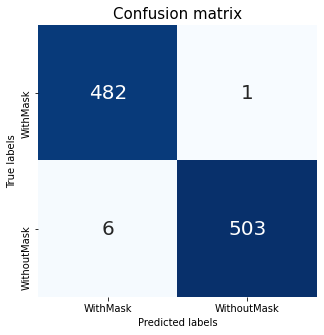

In [52]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred),xticklabels=CLASSES,yticklabels=CLASSES, ax=ax, annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 20}, cmap = 'Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.title("Confusion matrix",fontsize=15)
plt.show()

In [53]:
# Plotting model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Plotting this model with Jupyter notebook may be have a issue, [check it out](https://newbedev.com/keras-plot-model-tells-me-to-install-pydot).

# 7. Face detection model
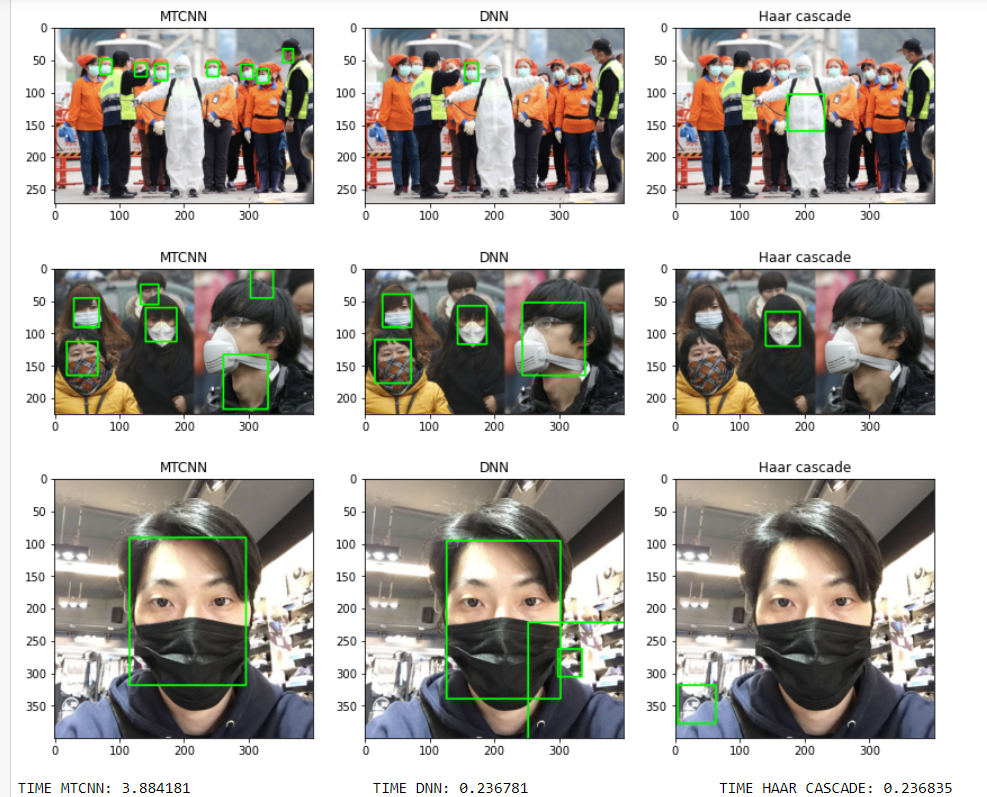


We have 4 options for detector: Haar, dlib, Multi-task Cascaded Convolutional Neural Network (MTCNN), and OpenCV’s DNN module.  
- Haar is pretty outdated and gives the worst results generally.  
- The face detection model of the DNN module of OpenCV works well but if the size of the image is very large then it can cause problems. 
- Dlib does not detect faces smaller than 80x80.
- So considering the above two points, MTCNN would be the best bet if we were to deal with extreme face sizes and can be said to be leading the competition till now.  

<h3>=> We see here that the MTCNN model has a longer runtime than the rest of the models because this model is used Multitask Convolutional Networks so it will take a long time to process, but give good results<h3>

Get sample images [here](https://www.kaggle.com/andrewmvd/face-mask-detection)

In [54]:
import cv2
from mtcnn.mtcnn import MTCNN

In [55]:
mask_label = {0:'MASK', 1:'NO MASK'}
color_label = {0:(0,255,0), 1:(255,0,0)}

In [71]:
detector = MTCNN()
# img_path = '../data/images/maksssksksss5.png'
# img_path = '../data/images/maksssksksss42.png'
# img_path = '../data/images/maksssksksss57.png'
# img_path = '../data/images/maksssksksss101.png'
# img_path = '../data/images/maksssksksss222.png'
img_path = r'C:\Users\DELL\Documents\may_hoc\Do_an\images\8.jpg'

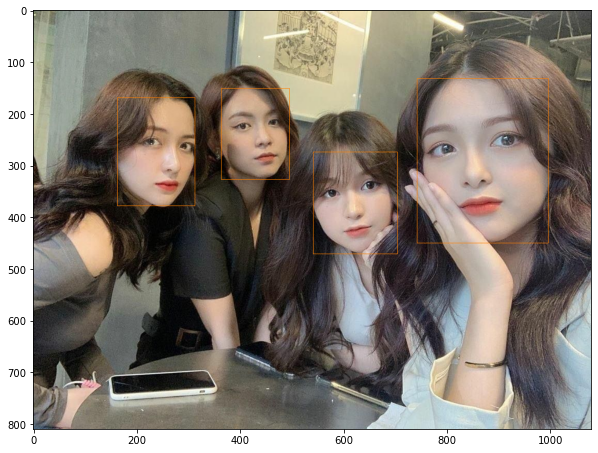

In [72]:
image = cv2.imread(img_path)
out_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # input MTCNN is RGB
detections = detector.detect_faces(out_image) # result
faces = [] # list of faces
# draw faces on image
for face in detections:
    faces.append(face['box'])
    x, y, w, h = face['box']
    cv2.rectangle(out_image, (x, y), (x+w, y+h), (255, 128, 0), 1)
# convert list to ndarray
faces = np.array(faces)
plt.figure(figsize=(10, 10))
plt.imshow(out_image)
plt.show()

[1, 1, 1, 1]


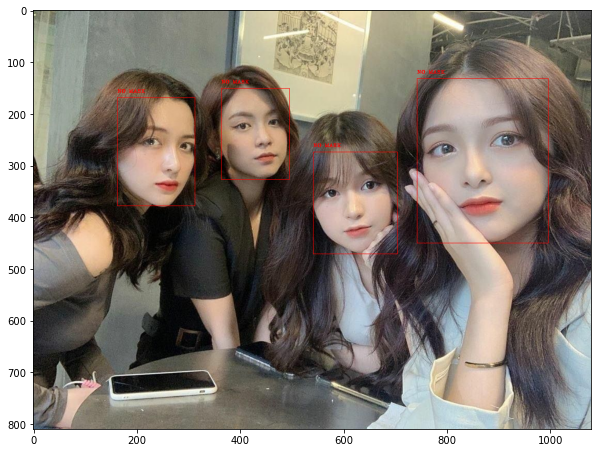

In [73]:
new_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #colored output image
classes = []
for i in range(len(faces)):
    (x,y,w,h) = faces[i]
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,TARGET_SIZE)
    crop = np.reshape(crop,[1,128,128,3])/255.0
    mask_result = model.predict(crop)
    classes.append(mask_result.argmax())
    cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,0.5,color_label[mask_result.argmax()],1)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),color_label[mask_result.argmax()],1)
print(classes)
plt.figure(figsize=(10,10))
plt.imshow(new_img)

## References  
[SHAHAF KARP](https://www.kaggle.com/shahf11/face-mask-detection-with-densenet201-99-6-acc)  
[NAGESH SINGH CHAUHAN](https://www.kaggle.com/nageshsingh/mask-and-social-distancing-detection-using-vgg19)  
**...**

In [ ]:
saved_model_dir = 'model_denseNet'
tf.saved_model.save(model, saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [96]:
# Convert the model https://www.tensorflow.org/lite/convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: C:\Users\vansy\AppData\Local\Temp\tmppytyosea\assets


INFO:tensorflow:Assets written to: C:\Users\vansy\AppData\Local\Temp\tmppytyosea\assets
